In [1]:
%pip install torch numpy pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


/opt/homebrew/Caskroom/miniconda/base/envs/xlstm/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/xlstm/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/xlstm/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([12, 1])). This will likel

Epoch 1/20, Train Loss: 27929.612890625, Val Loss: 12940.4404296875
Epoch 2/20, Train Loss: 31408.3107421875, Val Loss: 12954.260009765625
Epoch 3/20, Train Loss: 22068.489453125, Val Loss: 12996.6376953125
Epoch 4/20, Train Loss: 19497.14140625, Val Loss: 13027.828125
Epoch 5/20, Train Loss: 31158.552734375, Val Loss: 13043.16259765625
Epoch 6/20, Train Loss: 20037.7517578125, Val Loss: 13037.051025390625
Epoch 7/20, Train Loss: 26322.36796875, Val Loss: 13079.3671875
Epoch 8/20, Train Loss: 29671.1494140625, Val Loss: 13178.22607421875
Epoch 9/20, Train Loss: 27138.4412109375, Val Loss: 13198.4462890625
Epoch 10/20, Train Loss: 24374.57578125, Val Loss: 13148.08642578125
Epoch 11/20, Train Loss: 19942.825, Val Loss: 13087.15185546875
Epoch 12/20, Train Loss: 21533.865625, Val Loss: 13037.9296875
Epoch 13/20, Train Loss: 23920.2482421875, Val Loss: 13025.099365234375
Epoch 14/20, Train Loss: 37682.30078125, Val Loss: 13033.081787109375
Epoch 15/20, Train Loss: 37357.450390625, Val Los

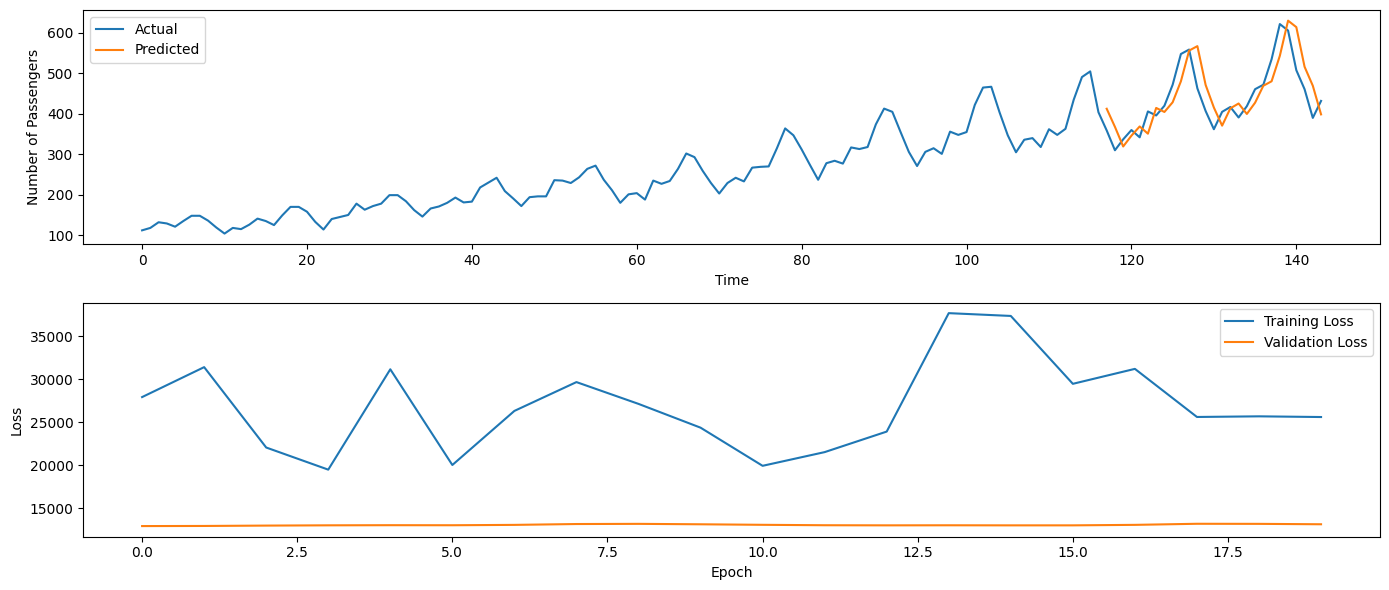

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from xlstm import xLSTM

# Define the dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_len]
        y = self.data[index + self.seq_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Load the data
def load_data(file_path):
    df = pd.read_csv(file_path, usecols=[1])
    data = df.values.astype(float).reshape(-1)
    return data

# Define the evaluation function for validation
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output, _ = model(x_batch.unsqueeze(-1))
            loss = criterion(output[-1], y_batch)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Define the evaluation function for full sequence
def evaluate_model_full_sequence(model, data, device, seq_len):
    model.eval()
    predictions = []
    data = torch.tensor(data, dtype=torch.float32).unsqueeze(-1).to(device)
    with torch.no_grad():
        for i in range(seq_len, len(data)):
            input_seq = data[i-seq_len:i].unsqueeze(1)  # Shape: (seq_len, 1, 1)
            output, _ = model(input_seq)
            prediction = output[-1].item()
            predictions.append(prediction)
    return predictions

# Define the training function
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=20):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output, _ = model(x_batch.unsqueeze(-1))
            loss = criterion(output[-1], y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_dataloader))

        # Evaluate on validation set
        val_loss = evaluate_model(model, val_dataloader, criterion, device)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")
    return train_losses, val_losses

# Parameters
file_path = 'AirPassengers.csv'  # Change this to your dataset path
seq_len = 12
batch_size = 16
hidden_size = 128
num_heads = 1
layers = ['m', 's', 'm']
learning_rate = 0.001
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
data = load_data(file_path)
dataset = TimeSeriesDataset(data, seq_len)

# Split data into training, validation, and test sets
train_size = int(len(dataset) * 0.6)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define model
model = xLSTM(input_size=1, hidden_size=hidden_size, num_heads=num_heads, layers=layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train model
train_losses, val_losses = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs)

# Evaluate model on the test set
test_data = data[-(test_size + seq_len):]
predictions = evaluate_model_full_sequence(model, test_data, device, seq_len)

# Plot the results
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(data, label='Actual')
plt.plot(range(len(data) - test_size, len(data)), predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()

# Plot training and validation loss
plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
